In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import StrMethodFormatter
from datetime import timedelta
import numpy as np

print("Processing...")

# User settings

filename_baseline = '180217_2_15_RCJ_Baseline.csv'
filename_controlled = '180217_2_15_RCJ_LongMorningShed_Control.csv'
filename_controlled2 = '180111_1_15_NR_controlled.csv' # huge spike one
WORKING_DIR = r"C:\Users\danap\OCHRE_Working"

N = 409 # number of samples
days = 2
Prated = 0.5 # kW
N = N * Prated * days

A = 24
baseColor = 'blue'
pwrColor = 'red'
controlColor = 'darkorchid'
COPconstant = 4.16748

# Define the specific columns we care about
Ttrue_col = 'Water Heating Control Temperature (C)'
power_col = 'Water Heating Electric Power (kW)'

def ET(TF, COP, Tset):
    c = 0.291
    p = 8.3454
    V = 50
    return c * p * V * (Tset - TF) / COP

def collapse_to_composite(series, how="sum"):
    """ Collapse series into a single-day profile by summing/averaging by time of day. """
    df = series.copy().to_frame("val")
    df["time_of_day"] = df.index.time
    if how == "sum":
        return df.groupby("time_of_day")["val"].sum()
    elif how == "mean":
        return df.groupby("time_of_day")["val"].mean()
    else:
        raise ValueError("how must be 'sum' or 'mean'")

# -------------------------------
# Load aggregated CSV
# -------------------------------
agg_controlled = os.path.join(WORKING_DIR, filename_controlled)
agg_controlled2 = os.path.join(WORKING_DIR, filename_controlled2)
agg_baseline = os.path.join(WORKING_DIR, filename_baseline)

# -------------------------------
# Aggregate and compute ET at each timestep
# -------------------------------

def calc_ET_instant(tempC, COP, Tset_F):
    """Compute instantaneous ET in kWh at each timestep."""
    tempF = 9/5 * tempC + 32
    return ET(tempF, COP, Tset_F) / 1000.0  # kWh

def process_dataset(path):
    # Load raw CSV
    df_raw = pd.read_csv(path, index_col=0, parse_dates=True)

    # Compute instantaneous ET
    df_raw["ET (kWh)"] = calc_ET_instant(df_raw[Ttrue_col], COPconstant, 130)

    # Sum power and ET across all buildings at each timestep
    df_out = df_raw.groupby(df_raw.index).agg({
        'Water Heating Electric Power (kW)': 'sum',
        'ET (kWh)': 'sum'
    })

    # Add helper columns for time-of-day and date
    df_out["time_of_day"] = df_out.index.time
    df_out["date"] = df_out.index.date

    return df_out

# Process controlled and baseline datasets
df_controlled = process_dataset(agg_controlled)
df_controlled2 = process_dataset(agg_controlled2)
df_baseline   = process_dataset(agg_baseline)

# Extract instantaneous ET and power
power_control = df_controlled[power_col]
power_control2 = df_controlled2[power_col]
power_base    = df_baseline[power_col]

# Collapse to composite by time of day (sum/average across days)
ET_control = df_controlled.groupby("time_of_day")["ET (kWh)"].sum()
ET_control2 = df_controlled2.groupby("time_of_day")["ET (kWh)"].sum()
ET_base    = df_baseline.groupby("time_of_day")["ET (kWh)"].sum()


# -------------------------------
# Plot composite daily profiles
# -------------------------------

# Convert time_of_day index into datetime (midnight reference day)
ref_date = pd.to_datetime("2000-01-01")
ET_base.index = pd.to_datetime(ET_base.index.astype(str), format="%H:%M:%S").map(
    lambda t: ref_date.replace(hour=t.hour, minute=t.minute, second=0)
)
ET_control.index = ET_base.index  # ensure same reference

# Collapse power by time of day (to match ET)
comp_power_base = df_baseline.groupby("time_of_day")["Water Heating Electric Power (kW)"].sum()/N
comp_power_control = df_controlled.groupby("time_of_day")["Water Heating Electric Power (kW)"].sum()/N
comp_power_control2 = df_controlled2.groupby("time_of_day")["Water Heating Electric Power (kW)"].sum()/N * 2
comp_power_base.index = ET_base.index
comp_power_control.index = ET_base.index
comp_power_control2.index = ET_base.index

print('Done')


Processing...
Done


# hamburger plot (no bar)

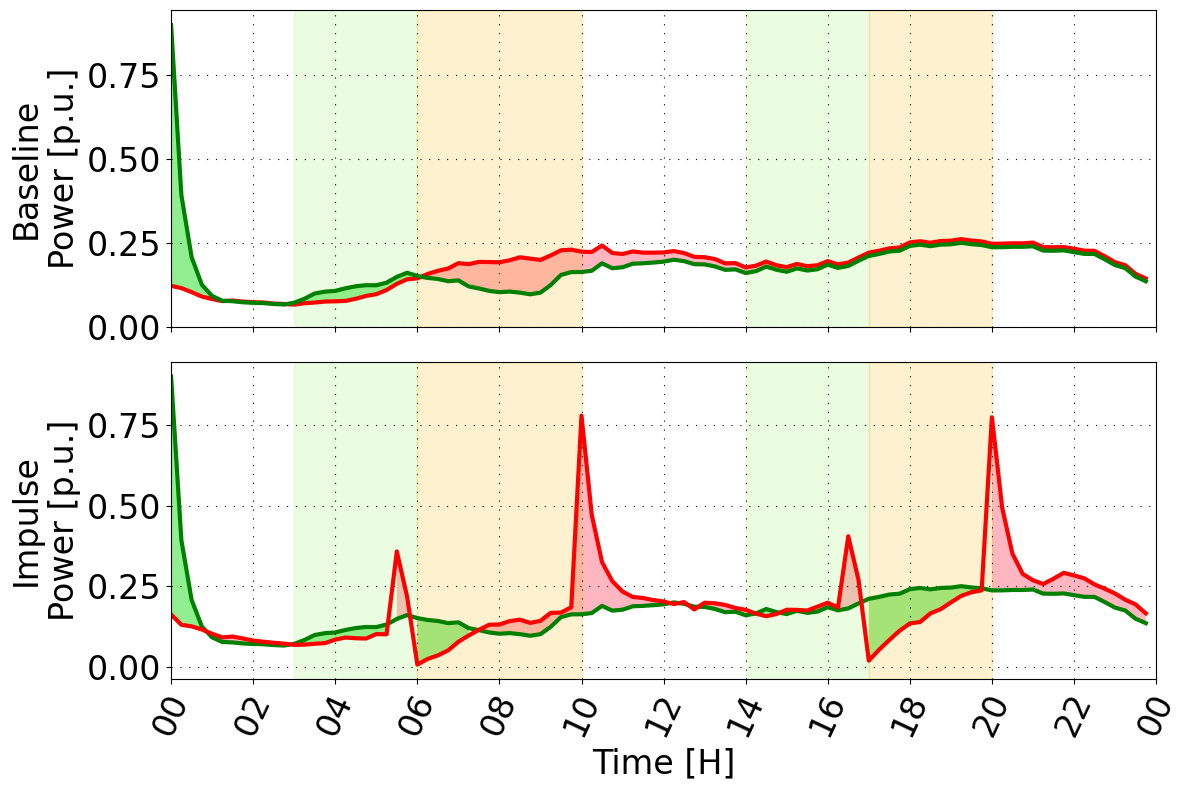

In [2]:
# # -------------------------------
# # Create stacked subplots (baseline on top, controlled on bottom)
# # -------------------------------
fig, (ax_base, ax_control) = plt.subplots(
    2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios':[1,1]}
)


# # -------------------------------
# # Baseline subplot
# # -------------------------------
ax_base.plot(comp_power_base.index, comp_power_base, color=pwrColor,
             label="Baseline Power (kW)", linewidth=3)
ax_base.set_ylabel("Baseline\nPower [p.u.]", fontsize=A, color='black')
ax_base.plot(comp_power_control.index, comp_power_control,
                color="green", label="Controlled2 Power (kW)", linewidth=3)
ax_base.tick_params(axis='y', labelcolor='black', labelsize=A)
ax_base.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
ax_base.fill_between(comp_power_control.index, comp_power_control, comp_power_base,
                        where=(comp_power_control < comp_power_base), alpha=1, linewidth=0, color='lightpink')
ax_base.fill_between(comp_power_control.index, comp_power_control, comp_power_base,
                        where=(comp_power_control > comp_power_base), alpha=1, linewidth=0, color='lightgreen')
ax_base.grid(True)

# # -------------------------------
# # Controlled subplot
# # -------------------------------
ax_control.plot(comp_power_control.index, comp_power_control,
                color='green', label="Controlled Power (kW)", linewidth=3)
ax_control.plot(comp_power_control2.index, comp_power_control2,
                color="red", label="Controlled2 Power (kW)", linewidth=3)
ax_control.set_ylabel("Impulse\nPower [p.u.]", fontsize=A, color='black')
ax_control.set_xlabel("Time [H]", fontsize=A, color='black')
ax_control.tick_params(axis='y', labelcolor='black', labelsize=A)
ax_control.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
ax_control.fill_between(comp_power_control.index, comp_power_control, comp_power_control2,
                        where=(comp_power_control < comp_power_control2), alpha=1, linewidth=0, color='lightpink')
ax_control.fill_between(comp_power_control.index, comp_power_control, comp_power_control2,
                        where=(comp_power_control > comp_power_control2), alpha=1, linewidth=0, color='lightgreen')
ax_control.grid(True)

# -------------------------------
# X-axis formatting (shared)
# -------------------------------
time_format = mdates.DateFormatter('%H')
ax_control.xaxis.set_major_formatter(time_format)
ax_control.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax_control.tick_params(axis='x', labelrotation=65, labelsize=A)

# X-axis range: midnight → midnight
for ax in [ax_base, ax_control]:
    ax.set_xlim(ref_date, ref_date + timedelta(days=1))
# =============================================================================

# -------------------------------
# Shade schedule periods
# -------------------------------
my_schedule = {
    'M_LU_time': '03:00', 'M_LU_duration': 3,
    'M_S_time': '06:00', 'M_S_duration': 4,
    'E_ALU_time': '14:00', 'E_ALU_duration': 3,
    'E_S_time': '17:00', 'E_S_duration': 3
}

periods = {
    "M_LU": {"color": "xkcd:light grass green"},
    "M_S": {"color": "xkcd:orangey yellow"},
    "E_ALU": {"color": "xkcd:light grass green"},
    "E_S": {"color": "xkcd:orangey yellow"}
}

def get_time_range(base_date, key_prefix):
    start = pd.to_datetime(f"{base_date.date()} {my_schedule[f'{key_prefix}_time']}")
    end = start + pd.Timedelta(hours=my_schedule[f'{key_prefix}_duration'])
    return start, end

# Apply shading to both subplots
for key, info in periods.items():
    start, end = get_time_range(ref_date, key)
    for ax in [ax_base, ax_control]:
        ax.axvspan(start, end, color=info['color'], alpha=0.2)

# -------------------------------
# Y-limits (synchronized)
# -------------------------------
max_power = max(comp_power_base.max(), comp_power_control.max(), comp_power_control2.max())
ax_base.set_ylim(0, max_power * 1.05)

ax_base.grid(True, linestyle=(0, (1, 7)), linewidth=0.8, color='black')
ax_control.grid(True, linestyle=(0, (1, 7)), linewidth=0.8, color='black')

plt.tight_layout()
plt.show()



# hamburger plot (with bar)

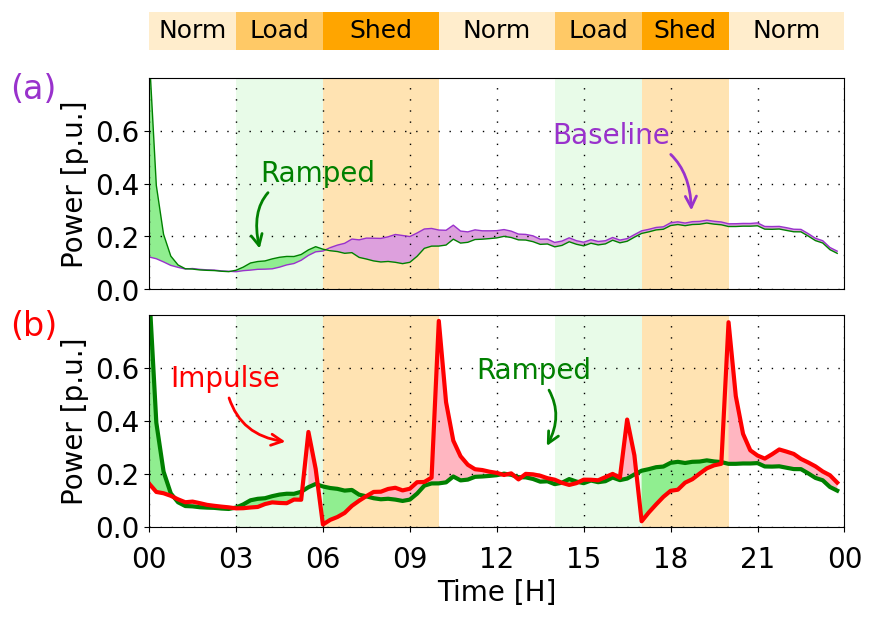

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import StrMethodFormatter
import pandas as pd
import numpy as np
from datetime import timedelta

# -------------------------------
# Add bars subplot above control power curve
# -------------------------------
def bars(ax, results, category_names):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    
    # Alpha = [0.2, 0.6, 1] # normal, loadup, shed
    Alpha = [0.2, 0.6, 1, 0.2, 0.6, 1, 0.2]
    text_color = ['black'] * len(category_names)

    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_yticks([])  
    ax.set_xlim(0, np.sum(data, axis=1).max())
    
    # Remove spines
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)
    
    # Plot stacked horizontal bars
    for i, colname in enumerate(category_names):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, color='orange', edgecolor='none', alpha=Alpha[i])
        
        for j, rect in enumerate(rects):
            ax.text(rect.get_x() + rect.get_width() / 2,
                    rect.get_y() + rect.get_height() / 2,
                    category_names[i],
                    ha='center', va='center', color=text_color[i], fontsize=18)


# -------------------------------
# Example data
# -------------------------------
results = {'': [3, 3, 4, 4, 3, 3, 4]}   # load, shed, end load
words = ['Norm', 'Load', 'Shed', 'Norm', 'Load', 'Shed', 'Norm']

# Dummy data setup (replace with your actual series)
ref_date = pd.Timestamp("2000-01-01")
time_index = pd.date_range(ref_date, periods=24, freq='h')

pwrColor = "red"
A = 20

# -------------------------------
# Create stacked subplots (bars on top, baseline middle, control bottom)
# -------------------------------
fig, (ax_bars, ax_base, ax_control) = plt.subplots(
    3, 1, figsize=(8.5, 6), 
    gridspec_kw={'height_ratios':[1, 5, 5]}, 
    sharex=False
)

# -------------------------------
# Bars subplot
# -------------------------------
bars(ax_bars, results, words)
ax_bars.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# -------------------------------
# Shade schedule periods
# -------------------------------
my_schedule = {
    'M_LU_time': '03:00', 'M_LU_duration': 3,
    'M_S_time': '06:00', 'M_S_duration': 4,
    'E_ALU_time': '14:00', 'E_ALU_duration': 3,
    'E_S_time': '17:00', 'E_S_duration': 3
}

periods = {
    "M_LU": {"color": "lightgreen", "hatch": 0.2},
    "M_S": {"color": "orange", "hatch": 0.3},
    "E_ALU": {"color": "lightgreen", "hatch": 0.2},
    "E_S": {"color": "orange", "hatch": 0.3}
}

def get_time_range(base_date, key_prefix):
    start = pd.to_datetime(f"{base_date.date()} {my_schedule[f'{key_prefix}_time']}")
    end = start + pd.Timedelta(hours=my_schedule[f'{key_prefix}_duration'])
    return start, end


# # Apply shading to both subplots
for key, info in periods.items():
    start, end = get_time_range(ref_date, key)
    for ax in [ax_base, ax_control]:
        ax.axvspan(start, end, facecolor=info['color'], edgecolor=info['color'], alpha = info['hatch'], linewidth=0) #hatch=info['hatch'], 




# -------------------------------
# Baseline subplot
# -------------------------------
ax_base.plot(comp_power_base.index, comp_power_base, color='darkorchid',
             label="Baseline Power (kW)", linewidth=1)
ax_base.set_ylabel("Power [p.u.]", fontsize=A, color='black')
ax_base.plot(comp_power_control.index, comp_power_control,
             color="green", label="Controlled Power (kW)", linewidth=1)
ax_base.tick_params(axis='y', labelcolor='black', labelsize=A)
ax_base.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))

ax_base.fill_between(comp_power_control.index, comp_power_control, comp_power_base,
                     where=(comp_power_control < comp_power_base), alpha=1, linewidth=0, color='plum')
ax_base.fill_between(comp_power_control.index, comp_power_control, comp_power_base,
                     where=(comp_power_control > comp_power_base), alpha=1, linewidth=0, color='lightgreen')

ax_base.tick_params(axis='x', bottom=False, labelbottom=False)
ax_base.grid(True)

# -------------------------------
# Controlled subplot
# -------------------------------
ax_control.plot(comp_power_control.index, comp_power_control,
                color='green', label="Controlled Power (kW)", linewidth=3)
ax_control.plot(comp_power_control2.index, comp_power_control2,
                color="red", label="Controlled2 Power (kW)", linewidth=3)
ax_control.set_ylabel("Power [p.u.]", fontsize=A, color='black')
ax_control.set_xlabel("Time [H]", fontsize=A, color='black')
ax_control.tick_params(axis='y', labelcolor='black', labelsize=A)
ax_control.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))

ax_control.fill_between(comp_power_control.index, comp_power_control, comp_power_control2,
                        where=(comp_power_control < comp_power_control2), alpha=1, linewidth=0, color='lightpink')
ax_control.fill_between(comp_power_control.index, comp_power_control, comp_power_control2,
                        where=(comp_power_control > comp_power_control2), alpha=1, linewidth=0, color='lightgreen')
ax_control.grid(True)

# -------------------------------
# X-axis formatting (shared style)
# -------------------------------
time_format = mdates.DateFormatter('%H')
hour_locator = mdates.HourLocator(interval=3)

# Apply same tick interval and format to both baseline and control subplots
for ax in [ax_base, ax_control]:
    ax.xaxis.set_major_formatter(time_format)
    ax.xaxis.set_major_locator(hour_locator)
    ax.set_xlim(ref_date, ref_date + timedelta(days=1))

# Control subplot shows x-axis labels
ax_control.tick_params(axis='x', labelrotation=0, labelsize=A, pad=10)

# Baseline subplot hides tick labels but keeps alignment
ax_base.tick_params(axis='x', bottom=False, labelbottom=False)


# -------------------------------
# Y-limits (synchronized)
# -------------------------------
max_power = max(comp_power_base.max(), comp_power_control.max(), comp_power_control2.max())
E = 1.05
ax_base.set_ylim(0, max_power * E)
ax_control.set_ylim(0, max_power * E)

ax_base.grid(True, linestyle=(0, (1, 7)), linewidth=1, color='black')
ax_control.grid(True, linestyle=(0, (1, 7)), linewidth=1, color='black')

#--------------------------------
# ADD ANNOTATION
#--------------------------------


C = 20
C = 20  # font size for annotations

def label(ax, title, color, x_coord, y_coord, x_text, y_text, arc):
    ax.annotate(
        title,
        xy=(float(x_coord), float(y_coord)),
        xycoords='axes fraction',  # relative to axes (0–1 range)
        xytext=(int(x_text), int(y_text)),
        textcoords='offset points',
        color=color,
        fontsize=C,
        rotation=0,
        arrowprops=dict(
            arrowstyle="->",
            color=color,
            linewidth=2,
            connectionstyle=f"arc3,rad={arc}"
        )
    )



label(ax_base, 'Baseline', 'darkorchid', 0.78, 0.36, -100, 50, -0.5)
label(ax_base, 'Ramped', 'green', 0.16, 0.18, 0, 50, 0.6)
label(ax_control, 'Impulse', 'red', 0.2, 0.4, -85, 40, 0.4)
label(ax_control, 'Ramped', 'green', 0.57, 0.37, -50, 50, -0.4)
# # Add subscript labels (a) and (b) with color
ax_base.text(-0.2, 0.9, '(a)', transform=ax_base.transAxes, fontsize=A+4, fontweight='normal', color='darkorchid')
ax_control.text(-0.2, 0.9, '(b)', transform=ax_control.transAxes, fontsize=A+4, fontweight='normal', color='red')


import matplotlib.ticker as ticker

for ax in [ax_base, ax_control]:
    ax.set_ylim(0, 0.8)
    ax.set_yticks([0, 0.2, 0.4, 0.6])




plt.tight_layout()
fig.tight_layout(pad=0.1)
RESULTS_DIR = r"C:\Users\danap\OCHRE_Working\Figs\base_impulse_controlled_DR.pdf"
plt.savefig(RESULTS_DIR, format='pdf', pad_inches=2)
plt.show()


In [12]:
diff = comp_power_control - comp_power_base

print((diff).to_string())

time_of_day
2000-01-01 00:00:00    0.776765
2000-01-01 00:15:00    0.277240
2000-01-01 00:30:00    0.104328
2000-01-01 00:45:00    0.035041
2000-01-01 01:00:00    0.009037
2000-01-01 01:15:00    0.001046
2000-01-01 01:30:00   -0.002079
2000-01-01 01:45:00   -0.002164
2000-01-01 02:00:00   -0.001840
2000-01-01 02:15:00   -0.001918
2000-01-01 02:30:00   -0.001313
2000-01-01 02:45:00   -0.001406
2000-01-01 03:00:00    0.005480
2000-01-01 03:15:00    0.013391
2000-01-01 03:30:00    0.026881
2000-01-01 03:45:00    0.029492
2000-01-01 04:00:00    0.031155
2000-01-01 04:15:00    0.037649
2000-01-01 04:30:00    0.037276
2000-01-01 04:45:00    0.032070
2000-01-01 05:00:00    0.026542
2000-01-01 05:15:00    0.021922
2000-01-01 05:30:00    0.020895
2000-01-01 05:45:00    0.019425
2000-01-01 06:00:00    0.007107
2000-01-01 06:15:00   -0.011626
2000-01-01 06:30:00   -0.024324
2000-01-01 06:45:00   -0.037816
2000-01-01 07:00:00   -0.051320
2000-01-01 07:15:00   -0.066347
2000-01-01 07:30:00   -0.079

# twinkie

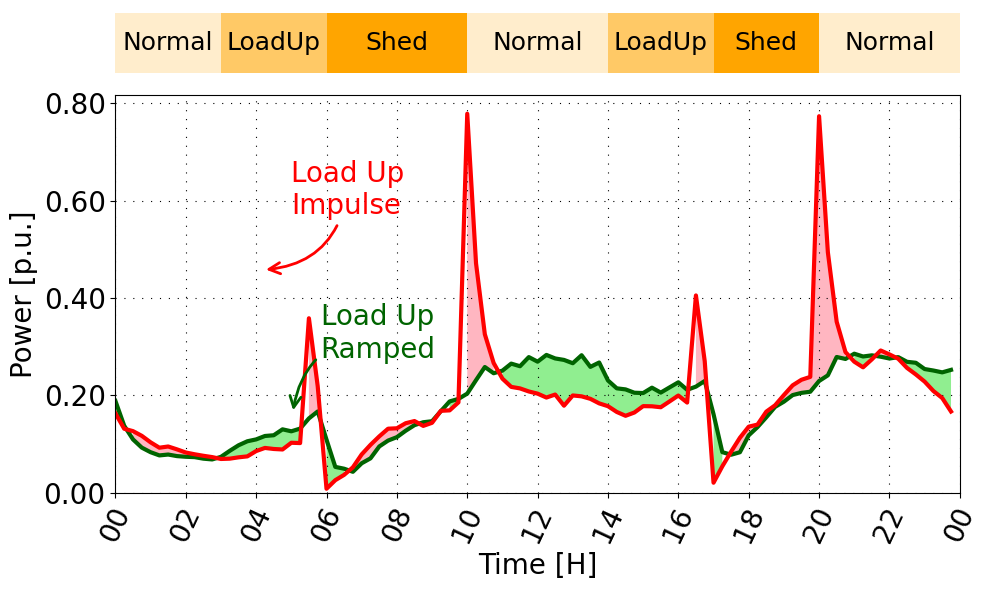

IndexError: index 0 is out of bounds for axis 0 with size 0

In [29]:


# -------------------------------
# Add bars subplot above control power curve
# -------------------------------
def bars(ax, results, category_names):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    
    # Alpha = [0.2, 0.6, 1] # normal, loadup, shed
    Alpha = [0.2, 0.6, 1, 0.2, 0.6, 1, 0.2]
    text_color = ['black', 'black', 'black', 'black', 'black', 'black', 'black']

    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_yticks([])  
    ax.set_xlim(0, np.sum(data, axis=1).max())
    
    # Remove spines
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)
    
    # Plot stacked horizontal bars
    for i, colname in enumerate(category_names):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, color='orange', edgecolor='none', alpha=Alpha[i])
        
        for j, rect in enumerate(rects):
            ax.text(rect.get_x() + rect.get_width() / 2,
                    rect.get_y() + rect.get_height() / 2,
                    category_names[i],
                    ha='center', va='center', color=text_color[i], fontsize=18)

# Example usage:
results = {'': [3, 3, 4, 4, 3, 3, 4]}   # load, shed, end load
words = ['Normal', 'LoadUp', 'Shed', 'Normal', 'LoadUp', 'Shed', 'Normal']

# -------------------------------
# Create two subplots: bars + controlled curve
# -------------------------------
fig, (ax_bars, ax_control) = plt.subplots(
    2, 1, figsize=(10, 6), 
    gridspec_kw={'height_ratios':[1, 6]}, 
    sharex=False
)

# Call bars function
bars(ax_bars, results, words)

# -------------------------------
# Controlled power curves
# -------------------------------
max_power = max(comp_power_base.max(), comp_power_control.max(), comp_power_control2.max())
ax_control.set_ylim(0, max_power * 1.05)

ax_control.plot(comp_power_control.index, comp_power_control, color='darkgreen', linewidth=3)
ax_control.plot(comp_power_control2.index, comp_power_control2, color="red", linewidth=3)
ax_control.fill_between(comp_power_control.index, comp_power_control, comp_power_control2,
                        where=(comp_power_control < comp_power_control2), alpha=1, linewidth=0, color='lightpink')
ax_control.fill_between(comp_power_control.index, comp_power_control, comp_power_control2,
                        where=(comp_power_control > comp_power_control2), alpha=1, linewidth=0, color='lightgreen')

ax_control.set_ylabel("Power [p.u.]", fontsize=A, color='black')
ax_control.set_xlabel("Time [H]", fontsize=A, color='black')
ax_control.tick_params(axis='y', labelcolor='black', labelsize=A)
ax_control.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
ax_control.grid(False)

# X-axis formatting (time of day)
time_format = mdates.DateFormatter('%H')
ax_control.xaxis.set_major_formatter(time_format)
ax_control.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax_control.tick_params(axis='x', labelrotation=65, labelsize=A)
ax_control.set_xlim(ref_date, ref_date + timedelta(days=1))
# ax_control.set_xlim(ref_date, ref_date + timedelta(hours=6))
# -------------------------------
# anotation zone
# -------------------------------
C = 20
def label(title, color, x_coord, y_coord, x_text, y_text, arc):
    ax_control.annotate(title, color=color, size=C, xy=(float(x_coord), float(y_coord)),\
        rotation=0, xycoords=ax_control.transAxes,\
        xytext=(int(x_text), int(y_text)), textcoords='offset points',\
        arrowprops=dict(arrowstyle="->", color=color, 
        linewidth=2, connectionstyle=f"arc3,rad={arc}"))


label('Load Up\nImpulse', 'red', 0.175, 0.56, 20, 40, -0.4)
label('Load Up\nRamped', 'darkgreen', 0.21, 0.2, 20, 40, 0.4)


# -------------------------------
# publish zone
# -------------------------------

plt.tight_layout()

ax_control.grid(True, linestyle=(0, (1, 7)), linewidth=0.8, color='black')
RESULTS_DIR = r"C:\Users\danap\OCHRE_Working\Figs\controlled_uncontrolled.pdf"
plt.savefig(RESULTS_DIR, format='pdf')
plt.show()

t = '05:09'
t_ref = pd.to_datetime(t, format='%H:%M').time()

value = comp_power_control2.loc[comp_power_control.index.time == t_ref].values[0]
value2 = comp_power_base.loc[comp_power_base.index.time == t_ref].values[0]
print(f"Impulse Power at {t} = {value:.3f} kW")
print(f"Base Power at {t} = {value2:.3f} kW")


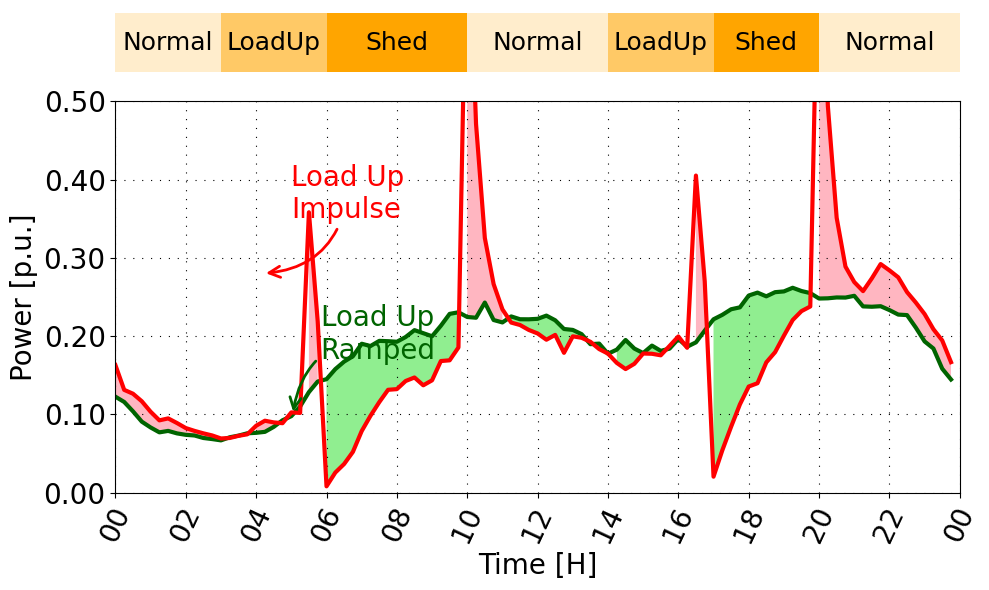

In [30]:


import datetime


# -------------------------------
# Add bars subplot above control power curve
# -------------------------------
def bars(ax, results, category_names):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    
    # Alpha = [0.2, 0.6, 1] # normal, loadup, shed
    Alpha = [0.2, 0.6, 1, 0.2, 0.6, 1, 0.2]
    text_color = ['black', 'black', 'black', 'black', 'black', 'black', 'black']

    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_yticks([])  
    ax.set_xlim(0, np.sum(data, axis=1).max())
    
    # Remove spines
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)
    
    # Plot stacked horizontal bars
    for i, colname in enumerate(category_names):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, color='orange', edgecolor='none', alpha=Alpha[i])
        
        for j, rect in enumerate(rects):
            ax.text(rect.get_x() + rect.get_width() / 2,
                    rect.get_y() + rect.get_height() / 2,
                    category_names[i],
                    ha='center', va='center', color=text_color[i], fontsize=18)

# Example usage:
results = {'': [3, 3, 4, 4, 3, 3, 4]}   # load, shed, end load
words = ['Normal', 'LoadUp', 'Shed', 'Normal', 'LoadUp', 'Shed', 'Normal']

# -------------------------------
# Create two subplots: bars + controlled curve
# -------------------------------
fig, (ax_bars, ax_control) = plt.subplots(
    2, 1, figsize=(10, 6), 
    gridspec_kw={'height_ratios':[1, 6]}, 
    sharex=False
)

# Call bars function
bars(ax_bars, results, words)

# -------------------------------
# Controlled power curves
# -------------------------------
max_power = max(comp_power_base.max(), comp_power_control.max(), comp_power_control2.max())
ax_control.set_ylim(0, 0.5) # max_power * 1.05

comp_power_basex = comp_power_base
comp_power_control2x = comp_power_control2

ax_control.plot(comp_power_base.index, comp_power_basex, color='darkgreen', linewidth=3)
ax_control.plot(comp_power_control2.index, comp_power_control2x, color="red", linewidth=3)
ax_control.fill_between(comp_power_control.index, comp_power_basex, comp_power_control2x,
                        where=(comp_power_basex < comp_power_control2x), alpha=1, linewidth=0, color='lightpink')
ax_control.fill_between(comp_power_control.index, comp_power_basex, comp_power_control2x,
                        where=(comp_power_basex > comp_power_control2x), alpha=1, linewidth=0, color='lightgreen')

ax_control.set_ylabel("Power [p.u.]", fontsize=A, color='black')
ax_control.set_xlabel("Time [H]", fontsize=A, color='black')
ax_control.tick_params(axis='y', labelcolor='black', labelsize=A)
ax_control.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
ax_control.grid(False)

# X-axis formatting (time of day)
time_format = mdates.DateFormatter('%H')
ax_control.xaxis.set_major_formatter(time_format)
ax_control.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax_control.tick_params(axis='x', labelrotation=65, labelsize=A)
ax_control.set_xlim(ref_date, ref_date + timedelta(days=1))
# ax_control.set_xlim(ref_date, ref_date + timedelta(hours=6))
# -------------------------------
# anotation zone
# -------------------------------
C = 20
def label(title, color, x_coord, y_coord, x_text, y_text, arc):
    ax_control.annotate(title, color=color, size=C, xy=(float(x_coord), float(y_coord)),\
        rotation=0, xycoords=ax_control.transAxes,\
        xytext=(int(x_text), int(y_text)), textcoords='offset points',\
        arrowprops=dict(arrowstyle="->", color=color, 
        linewidth=2, connectionstyle=f"arc3,rad={arc}"))


label('Load Up\nImpulse', 'red', 0.175, 0.56, 20, 40, -0.4)
label('Load Up\nRamped', 'darkgreen', 0.21, 0.2, 20, 40, 0.4)


# -------------------------------
# publish zone
# -------------------------------

plt.tight_layout()

ax_control.grid(True, linestyle=(0, (1, 7)), linewidth=0.8, color='black')
RESULTS_DIR = r"C:\Users\danap\OCHRE_Working\Figs\controlled_uncontrolled.pdf"
# plt.savefig(RESULTS_DIR, format='pdf')
plt.show()




In [19]:
print(comp_power_control2.to_string())

time_of_day
2000-01-01 00:00:00    0.156143
2000-01-01 00:03:00    0.153716
2000-01-01 00:06:00    0.153735
2000-01-01 00:09:00    0.153849
2000-01-01 00:12:00    0.149264
2000-01-01 00:15:00    0.149564
2000-01-01 00:18:00    0.139885
2000-01-01 00:21:00    0.139053
2000-01-01 00:24:00    0.130442
2000-01-01 00:27:00    0.131558
2000-01-01 00:30:00    0.125110
2000-01-01 00:33:00    0.124152
2000-01-01 00:36:00    0.118128
2000-01-01 00:39:00    0.109595
2000-01-01 00:42:00    0.105674
2000-01-01 00:45:00    0.106684
2000-01-01 00:48:00    0.110402
2000-01-01 00:51:00    0.110645
2000-01-01 00:54:00    0.110591
2000-01-01 00:57:00    0.105484
2000-01-01 01:00:00    0.103964
2000-01-01 01:03:00    0.105232
2000-01-01 01:06:00    0.100686
2000-01-01 01:09:00    0.104642
2000-01-01 01:12:00    0.100903
2000-01-01 01:15:00    0.092165
2000-01-01 01:18:00    0.086137
2000-01-01 01:21:00    0.087827
2000-01-01 01:24:00    0.089166
2000-01-01 01:27:00    0.084592
2000-01-01 01:30:00    0.083

In [23]:
import pandas as pd

# Example: 3-minute timestep
tres_minutes = 3
tres_hours = tres_minutes / 60  # convert to hours

# # If your index is datetime and you want between 6:00 and 10:00
start_time = "00:00:00"
stop_time = "23:57:00"
# start_time = "17:03:00"
# stop_time = "19:57:00"
# start_time = "00:03:00"
# stop_time = "23:57:00"

power_window = comp_power_base.between_time(start_time, stop_time)

# Calculate energy in kWh
energy_kwh = power_window.sum() * tres_hours

print(f"Energy from {start_time} to {stop_time}: {energy_kwh * N:.0f} kWh")

print(power_window.min())
print(power_window.max())

# RC: 1.8MWh
# Baseline: 1.8MWh
# NR:  1.8MWh


Energy from 00:00:00 to 23:57:00: 1833 kWh
0.04311134224500641
0.29416206223950514


In [2]:
x = [17, 21, 27, 37, 40, 46, 40, 42, 36, 32, 33, 38]
X = sum(x)
N = [round(i/X, 3) for i in x]

print(N)

[0.042, 0.051, 0.066, 0.09, 0.098, 0.112, 0.098, 0.103, 0.088, 0.078, 0.081, 0.093]
